In [1]:
import pandas as pd
import json
import plotly
import yaml
import requests

In [2]:
with open('/Users/dave/transfer/coros/creds.yml','r') as f:
    creds = yaml.safe_load(f)

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [4]:
# import requests

userId = creds.get('userId')
accessToken = creds.get('accessToken')
# print(userId, accessToken)

## need to update headers and params each time you proxy
headers = {
    'Host': 'api.coros.com',
    'accept': '*/*',
    # Already added when you pass json=
    # 'content-type': 'application/json',
    'yfheader': f'{{"userId":{userId},"appVersion":563005788913664,"releaseType":1,"clientType":2,"timezone":-20,"mobileName":"iOS","language":"en-US","systemVersion":"16.1.1","userSettingScope":"CAEQARgBIAE=","testFlightInstalled":0}}',
    'x-app-req-env': 'release-202209',
    'user-agent': 'Coros/2.13.14 (iPhone; iOS 15.7; Scale/3.00)',
    'accept-language': 'en-US;q=1',
}

params = {
    'accessToken': accessToken,
}

json_data = {
    'startTime': 20210101,
    'endTime': 20221111,
    'accessToken': accessToken,
    'dataType': [
        5,
        13,
    ],
    'dataVersion': 1,
    'statisticType': 1,
}

response = requests.post('https://api.coros.com/coros/data/statistic/daily', params=params, headers=headers, json=json_data)

In [5]:
response.status_code

200

In [6]:
# json_data = json.loads(response.text)

with open('/Users/dave/transfer/coros/coros-sleep-data.all.json','w') as f:
    f.write(response.text)


In [7]:
with open('/Users/dave/transfer/coros/coros-sleep-data.all.json','r') as f:
    json_data = json.load(f)

In [8]:
for dct in json_data.get('data').get('statisticData').get('dayDataList')[-1:-3]:
    print(dct)

### Dataframe and Graph(s)

In [8]:
import plotly.graph_objects as go

In [9]:
json_data.get('data').get('statisticData').get('dayDataList')[0]['sleepData']

{'avgHeartRate': 55,
 'deepTime': 146,
 'eyeTime': 0,
 'lightTime': 392,
 'maxHeartRate': 79,
 'minHeartRate': 46,
 'totalSleepTime': 538,
 'wakeTime': 33}

In [10]:
df = pd.json_normalize(json_data.get('data').get('statisticData').get('dayDataList'))

In [11]:
df.head()

,happenDay,performance,sleepList,sleepData.avgHeartRate,sleepData.deepTime,sleepData.eyeTime,sleepData.lightTime,sleepData.maxHeartRate,sleepData.minHeartRate,sleepData.totalSleepTime,sleepData.wakeTime
0,20221111,-1,[AA8AKAAAAMMAAABaAwAAELVtY+zkOm5j7LeMNAE7AiEAi...,55,146,0,392,79,46,538,33
1,20221110,-1,[AA8AKAAAAEsAAAAiAgAA6INsY+yw2Wxj7LaMNAFuAR4A/...,56,83,0,253,95,48,336,30
2,20221109,-1,[AA8AKAAAAJsAAAC4AgAA7CZrY+xwk2tj7LWMNAHPASQAH...,55,140,0,287,75,43,427,36
3,20221108,-1,[AA8AKAAAAK8AAABnAgAAHMtpY+z4Kmpj7LSMNAGZATcAA...,57,96,0,258,77,40,354,55
4,20221107,-1,[AA8AKAAAANcAAAAtAwAAjGtoY+zQ6mhj7LOMNAEfAisAX...,51,152,0,348,71,44,500,43


In [12]:
df['sleepDate'] = pd.to_datetime(df.happenDay, format='%Y%m%d')
df['sleepDate.weekDay'] = df['sleepDate'].apply(lambda x: x.strftime('%A'))

In [13]:
df['sleepDate'].describe(datetime_is_numeric=True)

count                              349
mean     2022-05-17 12:39:11.862464256
min                2021-11-23 00:00:00
25%                2022-02-18 00:00:00
50%                2022-05-17 00:00:00
75%                2022-08-13 00:00:00
max                2022-11-11 00:00:00
Name: sleepDate, dtype: object

In [14]:
df.loc[:,['sleepDate']].head()

,sleepDate
0,2022-11-11
1,2022-11-10
2,2022-11-09
3,2022-11-08
4,2022-11-07


In [29]:

# print(tick_df.columns.values)
# tick_values = tick_df.loc[:, ['sleepTime','deepTime','avgHR']].to_dict()
# print(tick_values)

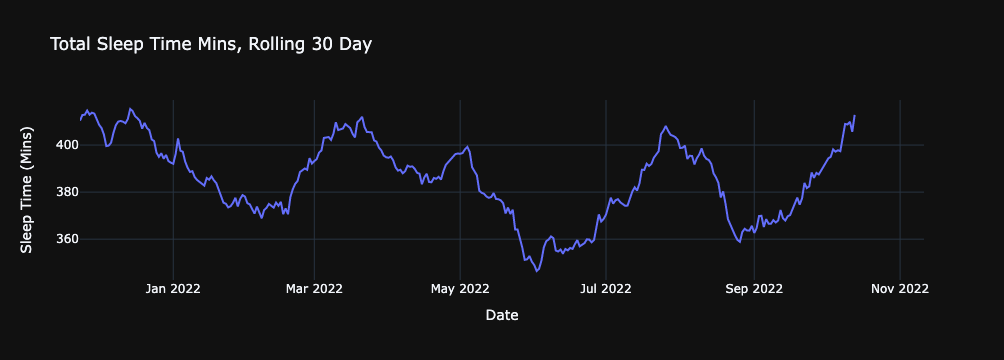

In [33]:
fig = go.Figure()

tick_values_df = df.rename(columns={'sleepData.totalSleepTime':'sleepTime', 'sleepData.deepTime':'deepTime', 'sleepData.avgHeartRate':'avgHR'})\
    .loc[:, ['sleepTime','deepTime','avgHR']]

tick_text = [f'Sleep Time: {sleepTime} mins<br> Deep Sleep Time: {deepTime} mins<br> Avg Heart Rate: {avgHR} bpm' 
             for (sleepTime, deepTime, avgHR) in tick_values_df.values]

fig.add_trace(
    go.Scatter(
        x = df['sleepDate']
        , y = df['sleepData.totalSleepTime'].rolling(window=30).mean()
        # , name = df['sleepDate.weekDay']
        # , mode='markers'
        , name='values'
        , text = tick_text
        , hoverinfo = 'text'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
    )
)
 
# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Total Sleep Time Mins, Rolling 30 Day',
                  yaxis_title='Sleep Time (Mins)',
                  xaxis_title='Date', 
                 )

# save file to html
# fig.write_json(os.path.abspath('../../personal-site/static/plotly/diamonds-forever/be-size-vs-carat.json'))

fig.show()

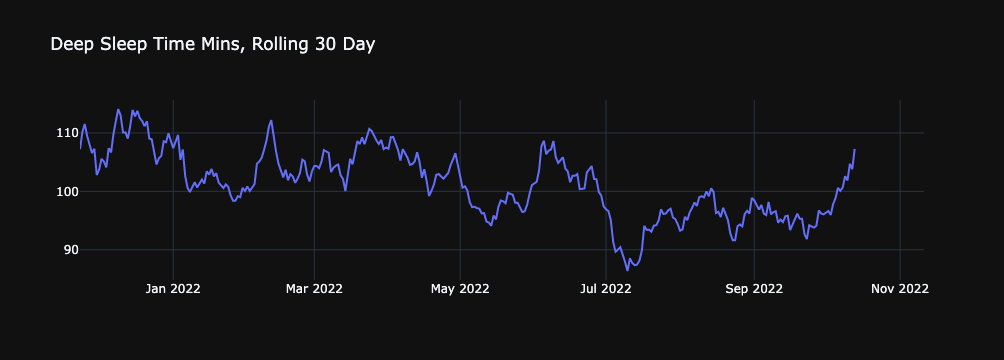

In [17]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = df['sleepDate']
        , y = df['sleepData.deepTime'].rolling(window=30).mean()
        # , name = df['sleepDate.weekDay']
        # , mode='markers'
        , name='values'
        # , text = ['Carat: %s<br>Measurements: %s mms'%(a,b) for a,b in graph_df.loc[:,['carat','measurements']].values]
        , hoverinfo = 'text'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
    )
)
 
# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Deep Sleep Time Mins, Rolling 30 Day',
                  # xaxis_title='Carat (0.2g)',
                  # yaxis_title='Approx. Horizontal Area (mm^2)', 
                 )

# save file to html
# fig.write_json(os.path.abspath('../../personal-site/static/plotly/diamonds-forever/be-size-vs-carat.json'))

fig.show()

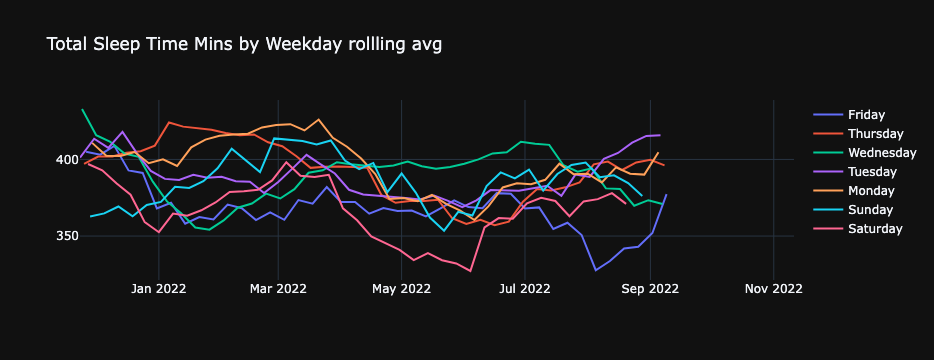

In [24]:
fig = go.Figure()

for wday in df['sleepDate.weekDay'].unique():
    

    fig.add_trace(
        go.Scatter(
            x = df.loc[df['sleepDate.weekDay'] == wday]['sleepDate']
            , y = df.loc[df['sleepDate.weekDay'] == wday]['sleepData.totalSleepTime'].rolling(window=10).mean()
            , name=wday
            # , text = ['Carat: %s<br>Measurements: %s mms'%(a,b) for a,b in graph_df.loc[:,['carat','measurements']].values]
            , hoverinfo = 'text'
            , marker=dict(
                colorscale='agsunset',
                line_width=1
            )
        )
    )
 
# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Total Sleep Time Mins by Weekday rollling avg',
                  # xaxis_title='Carat (0.2g)',
                  # yaxis_title='Approx. Horizontal Area (mm^2)', 
                 )

# # save file to html
# # fig.write_json(os.path.abspath('../../personal-site/static/plotly/diamonds-forever/be-size-vs-carat.json'))

fig.show()